In [1]:
include("source.jl")



load_skew_model (generic function with 1 method)

# construct grids

In [2]:
x= collect(LinRange(-pi,pi,101))
y = collect(LinRange(-pi,pi,101))
UPC = 1
fine_mesh = gen_mesh(x,y,UPC = UPC)

# number of unknowns per cell

J = (25,25) # compression in each direction
coarse_mesh = generate_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0



┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = ConvTranspose((25, 25), 1 => 1, stride=25, bias=false)  # 625 parameters
│   summary(x) = "4×4×1×1 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/HdfYB/src/layers/stateless.jl:60


0

# Function for RHS

In [3]:
function gen_conv_stencil(weights)
    widths = [(Int.(([size(weights)[1:end]...] .- 1) ./ 2)...,)]
    conv_stencil = conv_NN(widths,[1,1],[(1,1)],false)
    conv_stencil[1].weight[[(:) for i in 1:length(widths[1])]...] = weights#reverse(weights)
    return conv_stencil#conv_stencil
end

function gen_conv_advection_rhs(speed,viscosity)
    conv_D1 = gen_conv_stencil([[0, 1, 0];;[1, 0, -1];;[0, -1, 0]])
    conv_D2 = gen_conv_stencil([[0, 1, 0];;[1, -4, 1];;[0, 1, 0]])
    function advection_rhs(u,mesh,t,D1=conv_D1,D2 = conv_D2,viscosity =  viscosity,speed = speed)

        dx = mesh.omega[1,1]


        A = 1/(2*dx) * D1(u)
        B = (1/(dx^2))*D2(u)

        return -speed*A .+ viscosity*B
    end
    return advection_rhs
end


dudt = gen_conv_advection_rhs(0.1,0.00002)
#dudt = gen_conv_KdV_dudt()
rhs(u,mesh,t;dudt = dudt,other_arguments = 0) = dudt(padding(u,(1,1),circular = true),mesh,t)

rhs (generic function with 1 method)

# Initial conditions

In [4]:
max_k = 8
energy_norm = 0.5
number_of_simulations = 5

init_conds = generate_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (1,number_of_simulations))


100×100×1×5 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.0589586  -0.105195   -0.169532   …  -0.0508616  -0.0344317  -0.0354516
 -0.332023   -0.380143   -0.428928      -0.213867   -0.249876   -0.288401
 -0.597686   -0.646087   -0.677872      -0.375626   -0.461776   -0.535758
 -0.82982    -0.877362   -0.892863      -0.518941   -0.648383   -0.752721
 -1.0034     -1.0495     -1.05159       -0.626699   -0.788506   -0.915385
 -1.09802    -1.14253    -1.13586    …  -0.684772   -0.864799   -1.00425
 -1.10105    -1.14399    -1.13421       -0.684658   -0.866737   -1.00736
 -1.00989    -1.05104    -1.04382       -0.62535    -0.792711   -0.922563
 -0.832945   -0.871437   -0.871458      -0.514046   -0.65085    -0.75838
 -0.588968   -0.623037   -0.633044      -0.365507   -0.458346   -0.533369
 -0.30499    -0.331831   -0.352019   …  -0.200132   -0.239332   -0.273933
 -0.0129203  -0.0288094  -0.0565925     -0.0410079  -0.0216177  -0.010903
  0.254616    0.253976    0.223761       0.0895589   0.167232    0.2

# Generate training data

In [5]:
t_start = 0
t_end = 10
dt = 0.05
save_every = 1
pre_allocate = true


t_data,sim_data = simulate(init_conds,fine_mesh,dt,t_start,t_end,rhs,time_step,save_every = save_every,pre_allocate = pre_allocate) 
0

0

# Local POD

In [6]:
data = reshape(sim_data,(size(sim_data)[1:end-2]...,prod(size(sim_data)[end-1:end])))


100×100×1×1000 Array{Float64, 4}:
[:, :, 1, 1] =
  0.243708    0.255302    0.22404    …   0.00921428   0.109138    0.191972
  0.0234068   0.0111045  -0.0281308     -0.0613555   -0.0212821   0.0104164
 -0.217712   -0.254458   -0.300379      -0.142253    -0.166633   -0.189712
 -0.459039   -0.518854   -0.569883      -0.226842    -0.314562   -0.391274
 -0.676917   -0.756635   -0.811169      -0.305645    -0.449727   -0.574072
 -0.84774    -0.942616   -0.999172   …  -0.368105    -0.556154   -0.717652
 -0.951375   -1.05537    -1.11258       -0.404748    -0.619958   -0.804476
 -0.974378   -1.08048    -1.13695       -0.409294    -0.631955   -0.822896
 -0.912425   -1.01306    -1.06715       -0.380283    -0.589634   -0.769416
 -0.771505   -0.858947   -0.908548      -0.321837    -0.498094   -0.649774
 -0.567618   -0.634505   -0.676872   …  -0.243384    -0.369727   -0.478617
 -0.324947   -0.364809   -0.396547      -0.158321    -0.222626   -0.277738
 -0.0727372  -0.0805301  -0.0977613     -0.0818588

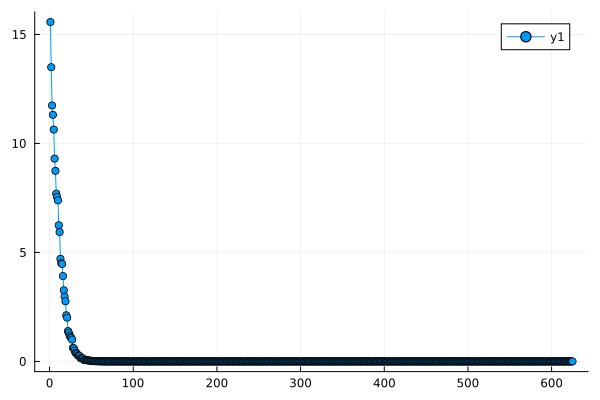

In [7]:
conserve_momentum = true
### momentum conserving correction of data set

data_hat = sqrt.(MP.omega_tilde) .* data
#reshape_for_local_SVD(data_hat,MP)

POD_modes,S = carry_out_local_SVD(data_hat,MP,subtract_average = conserve_momentum)

plot(S,marker = true)


In [8]:
r = 25 #how many modes to include, including u_bar

if conserve_momentum 
    if r >= UPC + 1

        global_POD_modes = local_to_global_modes(POD_modes[[(:) for i in 1:fine_mesh.dims]...,:,1:(r-UPC)],MP)

    else
        global_POD_modes = 0
    end

    global_POD_modes = add_filter_to_modes(global_POD_modes,MP,orthogonalize = false)

else
    global_POD_modes = local_to_global_modes(POD_modes[[(:) for i in 1:fine_mesh.dims]...,:,1:r],MP)
end

PO = gen_projection_operators(global_POD_modes,MP,uniform =false)


projection_operators_struct(var"#Phi_T#64"{Array{Float64, 4}, mesh_pair_struct}([0.040000000588415636 0.04000000058841592 … 0.04000000058841592 0.040000000588415636; 0.04000000058841592 0.040000000588416205 … 0.040000000588416205 0.04000000058841592; … ; 0.04000000058841592 0.040000000588416205 … 0.040000000588416205 0.04000000058841592; 0.040000000588415636 0.04000000058841592 … 0.04000000058841592 0.040000000588415636;;;; -0.011561976272104452 -0.011372848380521234 … 0.04715210163140351 0.04172099853655661; -0.01505937184017999 -0.015205443810601613 … 0.05349871656539673 0.04757855736537853; … ; -0.0021001687894127152 -0.005388514469474699 … 0.010339682967465387 0.011468259292687164; 0.00010397440584119908 -0.002680795782879534 … 0.007807661553758874 0.009223027889939216;;;; 0.01565842534524356 0.01980887345905929 … 0.010766411804599713 0.01019942738922836; 0.019437604488266924 0.024107788314680304 … 0.011014946091413689 0.010391206332293132; … ; 0.010471613209448748 0.00892562293176

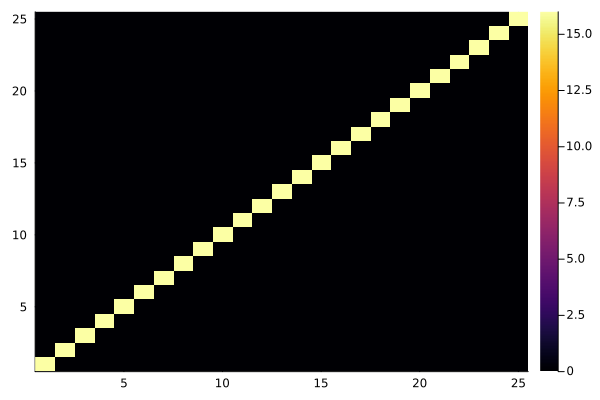

In [9]:
heatmap(compute_overlap_matrix(global_POD_modes))

# generate reference data

In [10]:
ref_rhs_data = PO.W(rhs(data,fine_mesh,0))
ref_data = PO.W(data)


4×4×25×1000 Array{Float32, 4}:
[:, :, 1, 1] =
  0.00661502  -0.100616   -0.167332    0.0093603
 -0.0173101   -0.0486683   0.17935    -0.138623
 -0.157936    -0.325439    0.124384   -0.0918692
 -0.0253903   -0.0595344   0.0479257   0.00106783

[:, :, 2, 1] =
 0.124756    0.0265595  0.123021   -0.0132391
 0.201054   -0.0648241  0.0846046   0.00782752
 0.32339     0.0336381  0.15004    -0.159772
 0.0343361  -0.153809   0.0676832   0.0378446

[:, :, 3, 1] =
 -0.136052    0.0304636   0.238242   0.276152
  0.0758837   0.129977    0.304459   0.0666322
 -0.100715    0.0705174   0.163056  -0.237323
  0.135001   -0.108314   -0.259557  -0.0515047

;;; … 

[:, :, 23, 1] =
  0.00484616  -0.00230675   -0.0130213    0.0128913
  0.00358902   0.000989063  -0.0151412   -0.00599722
 -0.00207873   0.0376351     0.0121784    0.00394623
 -0.0166916    0.00328994   -0.00721254  -0.00130478

[:, :, 24, 1] =
  0.000663143   0.0137127   0.0134155   0.0118679
 -0.0191414     0.0213874   0.0212771   0.012046
  0.

In [11]:
r

25

# Neural network

In [12]:

kernel_sizes = [(1,1),(1,1)]
channels = [r+1,20] # r+1 as the first channel for the rhs
strides = [(1,1),(1,1)]
B = (1,1)
boundary_padding = "c" #[["c","c"];;[0,0]]


constrain_energy =true
dissipation = true
conserve_momentum =true


model = gen_skew_NN(kernel_sizes,channels,strides,r,B,boundary_padding = boundary_padding,UPC = coarse_mesh.UPC,constrain_energy = constrain_energy,dissipation = dissipation,conserve_momentum = conserve_momentum)

skew_model_struct(var"#NN#198"{String, Bool, Bool, Bool, Int64, Tuple{Int64, Int64}, var"#NN#192#199", Vector{Array{Float64, 4}}, Chain{Tuple{Conv{2, 2, typeof(relu), Array{Float32, 4}, Vector{Float32}}, Conv{2, 2, typeof(identity), Array{Float32, 4}, Vector{Float32}}}}}(Core.Box(1), "c", true, true, true, 25, (1, 1), var"#NN#192#199"(Core.Box([0.10008145123720169 0.0085859140381217 0.041054900735616684; 0.02614467963576317 -0.060879483819007874 0.05114300176501274; -0.035980451852083206 0.038125935941934586 0.07608795166015625;;; 0.06829497963190079 -0.03178881108760834 -0.046518657356500626; -0.04643914848566055 -0.06011568754911423 -0.10321351140737534; -0.039439909160137177 -0.09200375527143478 0.01913902722299099;;; -0.03327552601695061 0.08470595628023148 0.10369750112295151; -0.08226204663515091 -0.10168799012899399 0.10438541322946548; 0.003451296593993902 0.04658119007945061 0.0027732138987630606;;; … ;;; 0.09854608029127121 0.057939425110816956 -0.07154304534196854; -0.112516

In [13]:
function neural_rhs(a,coarse_mesh,t,rhs = rhs,model = model,B=B;other_arguments = 0)
    dims = coarse_mesh.dims
    coarse_rhs = rhs(a[[(:) for i in 1:dims]...,1:1,:],coarse_mesh,t)
    input = cat(a,coarse_rhs,dims = dims + 1)
    
    lit = padding(a,((2*[B...])...,),circular = true)

    
    nn_output = model.eval(input,a = padding(a,((2*[B...])...,),circular = true)) #+ channel_mask .* coarse_rhs
    
    
    
    channel_mask = gen_channel_mask(nn_output,1)

    return  channel_mask .* coarse_rhs  + (1 ./ coarse_mesh.omega) .* nn_output 
end

neural_rhs (generic function with 4 methods)

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float64
│   T1 = Float32
│   T2 = Float64
└ @ NNlib ~/.julia/packages/NNlib/lOntC/src/conv.jl:192


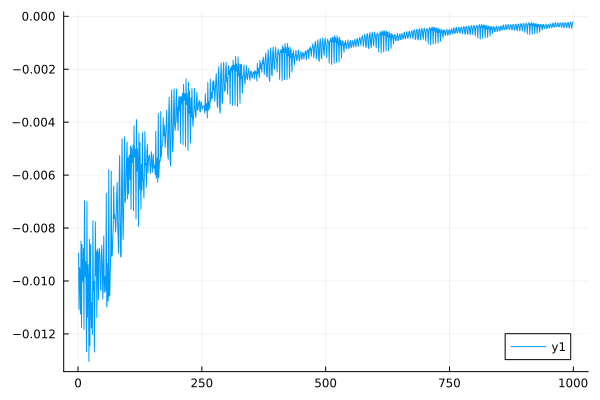

In [14]:
plot(coarse_mesh.ip(ref_data,neural_rhs(ref_data,coarse_mesh,0))[1:end]) # check if model is dissipative

# derivative fitting

In [15]:
batchsize = 50
derivative_fitting_data_loader = Flux.Data.DataLoader((ref_data,ref_rhs_data), batchsize=batchsize,shuffle=true)

20-element DataLoader(::Tuple{Array{Float32, 4}, Array{Float32, 4}}, shuffle=true, batchsize=50)
  with first element:
  (4×4×25×50 Array{Float32, 4}, 4×4×25×50 Array{Float32, 4},)

In [16]:
function derivative_fitting_loss(a,rhs_a,neural_rhs =neural_rhs,coarse_mesh = coarse_mesh)
    
    pred = neural_rhs(a,coarse_mesh,0)

    return Flux.Losses.mse(pred,rhs_a) #+ Flux.Losses.mse(coarse_mesh.ip(pred,a),coarse_mesh.ip(rhs_a,a))
end
    

derivative_fitting_loss (generic function with 3 methods)

In [17]:
sqrt.(derivative_fitting_loss(ref_data,ref_rhs_data))

0.43830666274083385

In [18]:
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [39]:
ps = Flux.params(model.CNN,model.B_mats...)
#ps = Flux.params(model.CNN)
epochs =40
losses = zeros(epochs)
epoch = 0 
for epoch in tqdm(1:epochs)
    Flux.train!(derivative_fitting_loss,ps, derivative_fitting_data_loader, opt)
    train_loss = derivative_fitting_loss(ref_data,ref_rhs_data)
    losses[epoch] = train_loss
end

0.0%┣                                               ┫ 0/40 [00:00<00:00, -0s/it]
2.5%┣█                                          ┫ 1/40 [00:03<Inf:Inf, InfGs/it]
5.0%┣██▍                                             ┫ 2/40 [00:06<03:53, 6s/it]
7.5%┣███▋                                            ┫ 3/40 [00:09<02:52, 5s/it]
10.0%┣████▊                                          ┫ 4/40 [00:13<02:34, 4s/it]
12.5%┣█████▉                                         ┫ 5/40 [00:17<02:30, 4s/it]
15.0%┣███████                                        ┫ 6/40 [00:21<02:24, 4s/it]
17.5%┣████████▎                                      ┫ 7/40 [00:25<02:18, 4s/it]
20.0%┣█████████▍                                     ┫ 8/40 [00:29<02:14, 4s/it]
22.5%┣██████████▋                                    ┫ 9/40 [00:33<02:09, 4s/it]
25.0%┣███████████▌                                  ┫ 10/40 [00:37<02:04, 4s/it]
27.5%┣████████████▋                                 ┫ 11/40 [00:41<02:00, 4s/it]
30.0%┣█████████████▉        

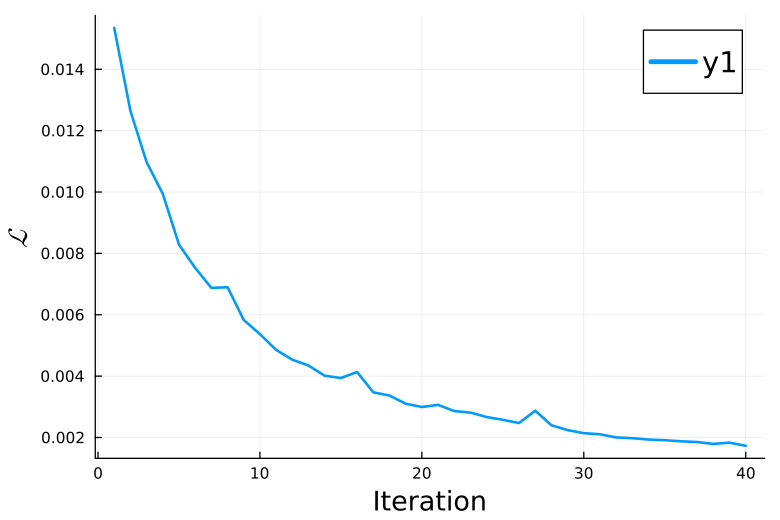

In [40]:

plot(sqrt.(losses),xguidefontsize=14,yguidefontsize=14 ,dpi = 130, legend=:topright,legendfont=font(15),linewidth = 2)
xlabel!("Iteration")
ylabel!(L"\mathcal{L}")

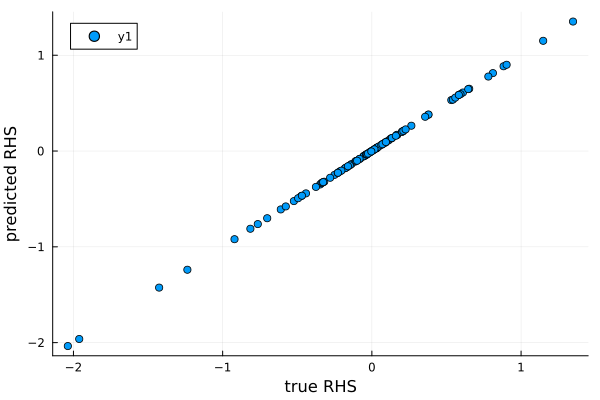

In [41]:
preds = neural_rhs(ref_data,coarse_mesh,0)

select = rand(collect(1:prod(size(ref_rhs_data))),(100))
scatter(ref_rhs_data[select],preds[select])
xlabel!("true RHS")
ylabel!("predicted RHS")

# Trajectory fitting

In [22]:
simulation_indexes = collect(1:size(sim_data)[end-1])'
simulation_indexes = cat([simulation_indexes for i in 1:size(sim_data)[end]]...,dims = fine_mesh.dims + 2)
simulation_indexes = simulation_indexes[1:end]
simulation_times = t_data[1:end]

ref_data_trajectory = reshape(ref_data,(size(ref_data)[1:coarse_mesh.dims+1]...,size(sim_data)[end-1],size(sim_data)[end]))
        

sim_interpolator = gen_time_interpolator(t_data,ref_data_trajectory)





(::var"#interpolator_function#172"{Array{Float64, 5}, Array{Float32, 5}, var"#interpolator_function#161#173"}) (generic function with 1 method)

In [23]:
# remove data that lies at the end of the simulation
buffer_dt = 1
select = buffer_dt .< maximum(simulation_times) .- simulation_times

traj_data = ref_data[[(:) for i in 1:coarse_mesh.dims+1]...,select]
traj_indexes = simulation_indexes[select]
traj_times = simulation_times[select]

900-element Vector{Float64}:
 0.05
 0.05
 0.05
 0.05
 0.05
 0.1
 0.1
 0.1
 0.1
 0.1
 0.15000000000000002
 0.15000000000000002
 0.15000000000000002
 ⋮
 8.899999999999991
 8.899999999999991
 8.949999999999992
 8.949999999999992
 8.949999999999992
 8.949999999999992
 8.949999999999992
 8.999999999999993
 8.999999999999993
 8.999999999999993
 8.999999999999993
 8.999999999999993

In [24]:
traj_dt = 0.1
traj_steps = 5

function trajectory_fitting_loss(input,indexes,times,dt = traj_dt,steps = traj_steps,sim_interpolator = sim_interpolator,neural_rhs = neural_rhs,coarse_mesh = coarse_mesh)
    dims = length(size(input)) - 2
    
    t_start = reshape(times,([1 for i in 1:dims+1]...,size(times)[1]))
    t_end =  t_start .+ steps *dt
        
    t,result = simulate(input,coarse_mesh,dt,t_start,t_end,neural_rhs,time_step,save_every = 1,pre_allocate = false) 
    reference = stop_gradient() do
        sim_interpolator(t,simulation_indexes = indexes)
    end
    return Flux.Losses.mse(result,reference)
end    
    
    
    
    

trajectory_fitting_loss (generic function with 6 methods)

In [25]:
batchsize = 20
trajectory_fitting_data_loader = Flux.Data.DataLoader((traj_data,traj_indexes,traj_times), batchsize=batchsize,shuffle=true)

45-element DataLoader(::Tuple{Array{Float32, 4}, Vector{Int64}, Vector{Float64}}, shuffle=true, batchsize=20)
  with first element:
  (4×4×25×20 Array{Float32, 4}, 20-element Vector{Int64}, 20-element Vector{Float64},)

In [26]:
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [27]:
select = rand(collect(1:prod(size(traj_indexes))),(200))
trajectory_fitting_loss(traj_data[:,:,:,select],traj_indexes[select],traj_times[select])

3.071156144301632e-5

In [28]:
ps = Flux.params(model.CNN)
epochs =0
losses = zeros(epochs)
for epoch in tqdm(1:epochs)
    Flux.train!(trajectory_fitting_loss,ps, trajectory_fitting_data_loader, opt)
    train_loss = trajectory_fitting_loss(traj_data[:,:,:,select],traj_indexes[select],traj_times[select])
    losses[epoch] = train_loss
end

┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 0it 00:00 [-0s/it]


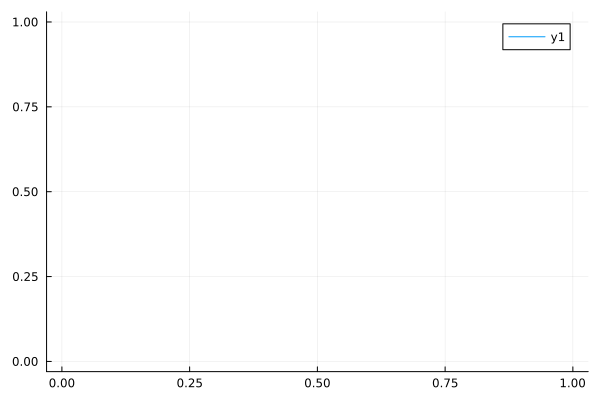

In [29]:
plot(losses)

In [30]:
save_skew_model(model, "my_model")
model = load_skew_model("my_model")


Model saved at directory [my_model]

Model loaded from directory [my_model]


skew_model_struct(var"#NN#198"{String, Bool, Bool, Bool, Int64, Tuple{Int64, Int64}, var"#NN#192#199", Vector{Array{Float64, 4}}, Chain{Tuple{Conv{2, 2, typeof(relu), Array{Float32, 4}, Vector{Float32}}, Conv{2, 2, typeof(identity), Array{Float32, 4}, Vector{Float32}}}}}(Core.Box(1), "c", true, true, true, 25, (1, 1), var"#NN#192#199"(Core.Box([0.11237529665231705 -0.0010786334751173854 0.08917222172021866; -0.001372243044897914 -0.09178680926561356 0.09229250997304916; 0.021635010838508606 0.028540922328829765 -0.00035694288089871407;;; -0.05324988812208176 0.02200639434158802 -0.0015772468177601695; -0.044406965374946594 -0.09928028285503387 0.058217521756887436; 0.09666357934474945 0.08607219904661179 -0.0556330680847168;;; 0.046588487923145294 0.05189903452992439 0.03260703757405281; 0.06320328265428543 -0.06608373671770096 0.0004096907505299896; 0.10570499300956726 0.10112018138170242 -0.09756535291671753;;; … ;;; 0.07626322656869888 -0.07744108140468597 -0.04633451998233795; 0.00

# Online testing

In [31]:
max_k = 8
energy_norm = 0.5
number_of_simulations = 1

new_init_conds = generate_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (1,number_of_simulations))
#new_init_conds = init_conds[:,:,:,1:1]

100×100×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.355132   -0.251019   -0.0847409  …  -0.253626    -0.351049   -0.38814
 -0.477578   -0.338214   -0.133366      -0.418957    -0.515816   -0.537761
 -0.60602    -0.437558   -0.202862      -0.594101    -0.685222   -0.69072
 -0.730685   -0.541599   -0.28819       -0.765336    -0.846164   -0.835286
 -0.839285   -0.639658   -0.380176      -0.916776    -0.983577   -0.957644
 -0.918212   -0.718855   -0.466367   …  -1.03196     -1.08192    -1.04326
 -0.954215   -0.765714   -0.532596      -1.09573     -1.12703    -1.07863
 -0.936342   -0.768171   -0.565079      -1.09625     -1.108      -1.05319
 -0.857878   -0.717673   -0.552729      -1.02677     -1.01904    -0.961176
 -0.717969   -0.611046   -0.489324      -0.886977    -0.860793   -0.803051
 -0.522611   -0.451779   -0.375137   …  -0.683648    -0.640994   -0.586285
 -0.284794   -0.250459   -0.217713      -0.430418    -0.374291   -0.325295
 -0.0236832  -0.0241965  -0.0315853     -0.146707    -0.081

# Compute reference

In [61]:
t_start = 0
t_end = 5
dt = 0.05
save_every = 2
pre_allocate = true


t,test_sim = simulate(new_init_conds,fine_mesh,dt,t_start,t_end,rhs,time_step,save_every = save_every,pre_allocate = pre_allocate) 
0
t_test = t[1:end]
test_sim = test_sim[:,:,:,1,:]
W_test_sim = PO.W(test_sim)

4×4×25×50 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.0060062   0.0683738  -0.0267727   0.0205805
 -0.030777    0.0654173  -0.36219     0.0501368
  0.107381   -0.171985   -0.0955168  -0.0071171
  0.119324    0.298571   -0.052505   -0.398932

[:, :, 2, 1] =
 -0.166602    -0.00933422   0.0669421  0.0735769
  0.00038863  -0.163723    -0.0185019  0.0987241
  0.136992    -0.17764      0.0774451  0.148385
  0.10833     -0.103396    -0.0251659  0.0696021

[:, :, 3, 1] =
 -0.0929491     0.124176    0.239761   -0.0117473
 -0.00486585   -0.0227274  -0.013129    0.154121
  0.0442983     0.181956   -0.0329082  -0.00112427
  0.000404496   0.168438   -0.405661    0.0582011

;;; … 

[:, :, 23, 1] =
 -0.0259074    -0.0428506    0.0312604   0.0242556
 -0.0107727    -0.0224681    0.0117064   0.0137833
  0.000640467   0.0330923   -0.0129867  -0.025308
 -0.0498692     0.00959103   0.0312188  -0.00167606

[:, :, 24, 1] =
 -0.02107     -0.00143927   0.00250972   0.0356413
 -0.0167736    0.023885     0.0128588   -

# Compute prediction

In [62]:
t_start = 0
t_end = 5
dt = 0.1
save_every = 1
pre_allocate = true


t,pred_sim = simulate(PO.W(new_init_conds),coarse_mesh,dt,t_start,t_end,neural_rhs,time_step,save_every = save_every,pre_allocate = pre_allocate) 
t_pred = t[1:end]
pred_sim = pred_sim[:,:,:,1,:]

R_pred_sim = PO.R(pred_sim)

100×100×1×50 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.058042  -0.0984398  -0.116869   -0.105679     …   0.0836565    0.0844022
 -0.146136  -0.175767   -0.173805   -0.133731         0.0924782    0.0470517
 -0.265631  -0.281999   -0.257216   -0.186229         0.0509434   -0.0412006
 -0.412595  -0.414885   -0.36722    -0.266231        -0.0421323   -0.177712
 -0.577979  -0.567088   -0.498892   -0.371753        -0.180094    -0.352135
 -0.748026  -0.726334   -0.642073   -0.495222     …  -0.349052    -0.547391
 -0.905501  -0.876425   -0.78212    -0.623897        -0.529602    -0.741702
 -1.03162   -0.999055   -0.901539   -0.741296        -0.699397    -0.911399
 -1.10848   -1.0762     -0.982325   -0.829451        -0.836194    -1.0341
 -1.12154   -1.09275    -1.00866    -0.871659        -0.920906    -1.09176
 -1.06197   -1.03896    -0.969564   -0.855303     …  -0.940207    -1.0732
 -0.928274  -0.912368   -0.860999   -0.774247        -0.888308    -0.975669
 -0.72705   -0.718727   -0.687144   -0.6303

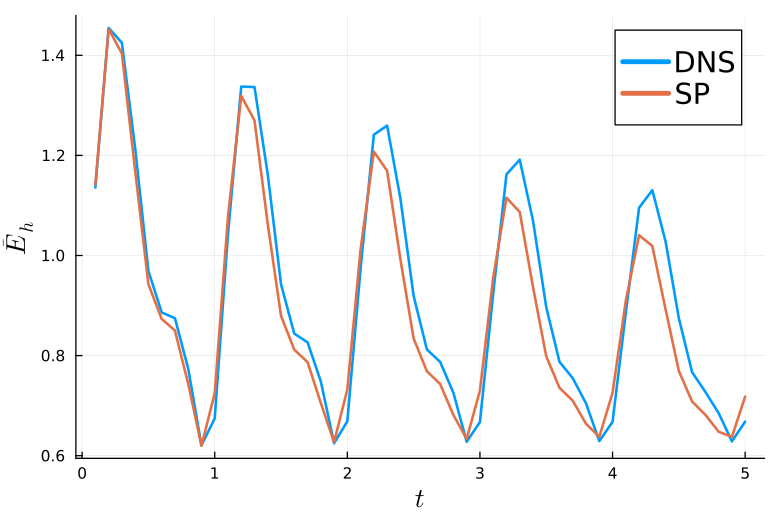

In [63]:
plot(t_test,coarse_mesh.ip(W_test_sim,W_test_sim,combine_channels = false)[1,1,1,:],label = "DNS",linewidth = 2,xguidefontsize=14,yguidefontsize=14 ,dpi = 130, legend=:topright,legendfont=font(15))
plot!(t_pred,coarse_mesh.ip(pred_sim,pred_sim,combine_channels = false)[1,1,1,:],label = "SP",linewidth = 2)
ylabel!(L"$\bar{E}_h$")
xlabel!(L"t")

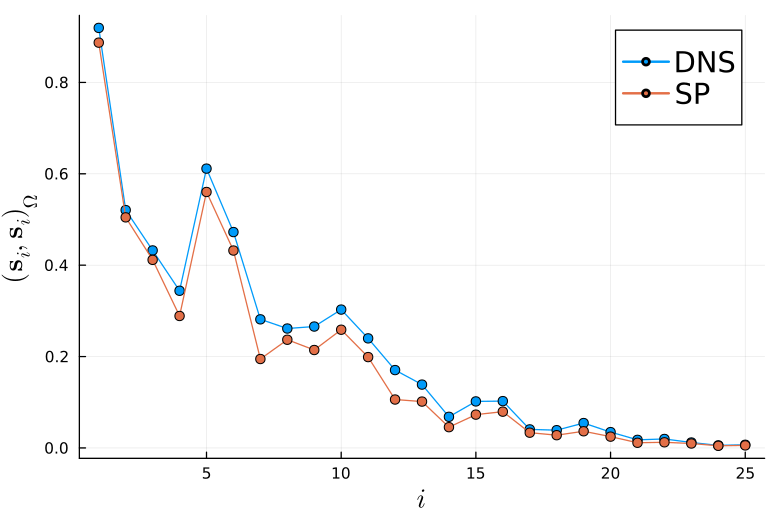

In [64]:
plot(mean(coarse_mesh.ip(W_test_sim,W_test_sim,combine_channels = false),dims = [1,2,4])[1:end],label = "DNS",marker = true,xguidefontsize=14,yguidefontsize=14 ,dpi = 130, legend=:topright,legendfont=font(15))
plot!(mean(coarse_mesh.ip(pred_sim,pred_sim,combine_channels = false),dims = [1,2,4])[1:end],label = "SP",marker = true)
xlabel!(L"i")
ylabel!(L"(\mathbf{s}_i,\mathbf{s}_i)_\Omega")

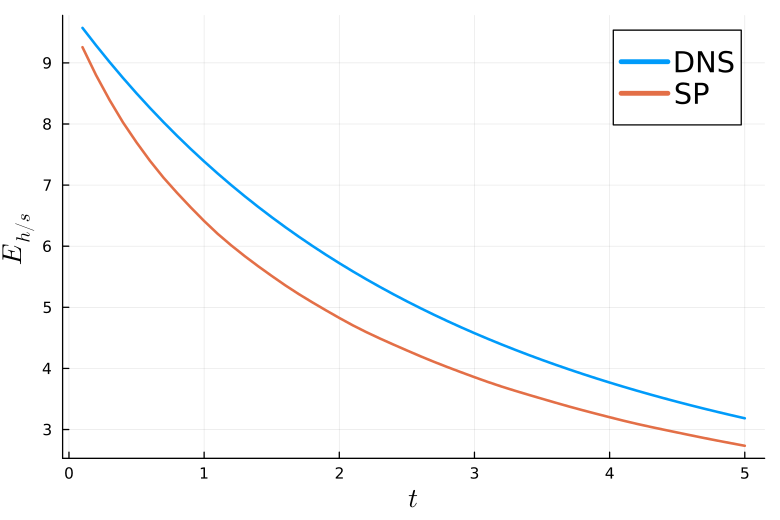

In [65]:
E_ref = fine_mesh.ip(test_sim,test_sim)[1:end]
E_pred = coarse_mesh.ip(pred_sim,pred_sim,combine_channels = true)[1:end]

plot(t_test,E_ref,label = "DNS",linewidth = 2,xguidefontsize=14,yguidefontsize=14 ,dpi = 130, legend=:topright,legendfont=font(15))
plot!(t_pred,E_pred,label = "SP",linewidth = 2)
ylabel!(L"$E_{h/s}$")
xlabel!(L"t")

[ Info: Saved animation to /home/toby/Projects/Local_POD/Test_local_POD/DNS_flow.gif


Plots.AnimatedGif("/home/toby/Projects/Local_POD/Test_local_POD/DNS_flow.gif")
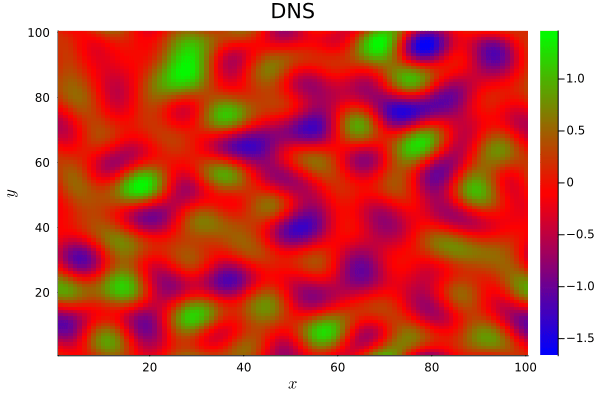

In [66]:
to_plot = test_sim

ymin = minimum(to_plot)
ymax = maximum(to_plot)

anim = @animate for index in 1:size(to_plot)[4]
    heatmap(to_plot[:,:,1,index],color = :brg,clim = (ymin,ymax))
    xlabel!(L"x")
    ylabel!(L"y")
    title!("DNS")
    
end


gif(anim, "DNS_flow.gif", fps = 10)

[ Info: Saved animation to /home/toby/Projects/Local_POD/Test_local_POD/SP_flow.gif


Plots.AnimatedGif("/home/toby/Projects/Local_POD/Test_local_POD/SP_flow.gif")
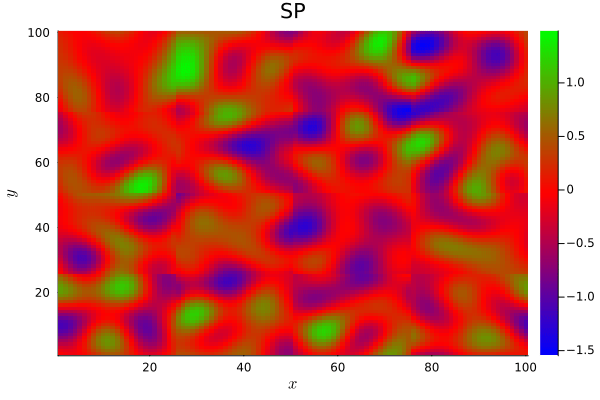

In [67]:
to_plot = R_pred_sim

ymin = minimum(to_plot)
ymax = maximum(to_plot)

anim = @animate for index in 1:size(to_plot)[4]
    heatmap(to_plot[:,:,1,index],color = :brg,clim = (ymin,ymax))
    xlabel!(L"x")
    ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
    title!("SP")
end


gif(anim, "SP_flow.gif", fps = 10)